In [1]:
!pip install pyspark
!pip install nltk
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=18621acfc0eebe65a8a7776ee6637434406785fd9e1e778b7099b1bcb4542224
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
import gdown
import os
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType, ArrayType
from pyspark.sql.functions import col, udf, split, explode, size, array_remove, array_contains, regexp_replace, lower, collect_list
from pyspark.ml.feature import StopWordsRemover, Tokenizer, HashingTF, IDF
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [3]:
file_id = '1w2c49UUWnZHbWZ_ryKaWGhIzSF7QuvYJ'
url = f'https://drive.google.com/uc?id={file_id}'
output_path = '/content/mental_health.csv'
if not os.path.exists(output_path):
    gdown.download(url, output_path, quiet=False)
else:
    print(f"The file '{output_path}' already exists.")

Downloading...
From: https://drive.google.com/uc?id=1w2c49UUWnZHbWZ_ryKaWGhIzSF7QuvYJ
To: /content/mental_health.csv
100%|██████████| 13.1M/13.1M [00:00<00:00, 110MB/s]


In [4]:
spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder\
        .master("local")\
        .appName("RDD")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

spark
sc = spark.sparkContext
sc.setCheckpointDir('checkpoint/')

In [5]:
spark.conf.set("spark.sql.shuffle.partitions", 16)
spark.conf.set("spark.default.parallelism", 16)
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", 104857600)

In [6]:
df = spark.read.csv(output_path, header=True, inferSchema=True)

In [7]:
df.show(5)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|dear american tee...|    0|
|nothing look forw...|    1|
|music recommendat...|    0|
|im done trying fe...|    1|
|worried  year old...|    1|
+--------------------+-----+
only showing top 5 rows



In [8]:
# Display summary statistics for numerical columns
df.describe().show()

# Display the schema of the DataFrame
df.printSchema()

+-------+--------------------+-------------------+
|summary|                text|              label|
+-------+--------------------+-------------------+
|  count|               27977|              27977|
|   mean|                NULL|0.49462058119169316|
| stddev|                NULL| 0.4999799966498138|
|    min|                    |                  0|
|    max|zoomposting real ...|                  1|
+-------+--------------------+-------------------+

root
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)



In [9]:
duplicate_count = df.count() - df.dropDuplicates().count()
print("Duplicate count:", duplicate_count)

Duplicate count: 5


In [10]:
df = df.dropDuplicates()

In [11]:
from pyspark.sql.functions import length, avg

df = df.withColumn("length", length("text"))

In [12]:
df_gede = df.filter(col('length') >= 4096)
df_gede.count()

136

In [13]:
df = df.subtract(df_gede)

In [14]:
df.describe().show()

+-------+--------------------+-------------------+-----------------+
|summary|                text|              label|           length|
+-------+--------------------+-------------------+-----------------+
|  count|               27836|              27836|            27836|
|   mean|                NULL|   0.49285098433683|436.9363414283661|
| stddev|                NULL|0.49995786946205906|542.3475517942358|
|    min|                    |                  0|                2|
|    max|zoomposting real ...|                  1|             4087|
+-------+--------------------+-------------------+-----------------+



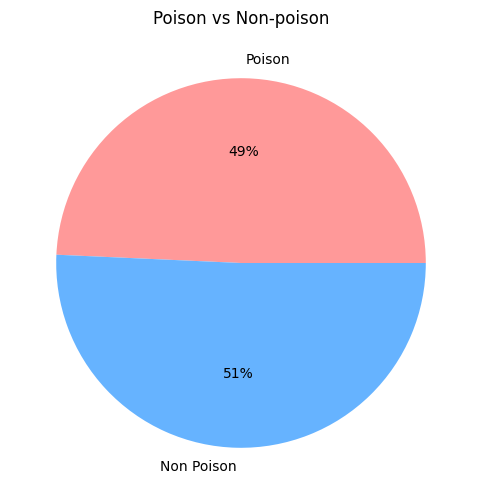

In [15]:
# Assuming 'label' is a boolean column in your DataFrame
sarcastic_counts = df.groupBy("label").count().collect()

# Extract counts
non_sarcastic_count = sarcastic_counts[0]["count"]
sarcastic_count = sarcastic_counts[1]["count"]

# Prepare data for pie chart
labels = ['Poison', 'Non Poison']
sizes = [non_sarcastic_count, sarcastic_count]
colors = ['#ff9999', '#66b3ff']

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.0f%%', colors=colors)
plt.title('Poison vs Non-poison')

# Display the pie chart
plt.show()


In [16]:
def extract_text(text):
    # Add more patterns as needed
    patterns = {
      r"\bim\b": "i am",
      r"\byoure\b": "you are",
      r"\bhes\b": "he is",
      r"\bshes\b": "she is",
      r"\bwere\b": "we are",
      r"\btheyre\b": "they are",
      r"\bive\b": "i have",
      r"\byouve\b": "you have",
      r"\bweve\b": "we have",
      r"\btheyve\b": "they have",
      r"\bwasnt\b": "was not",
      r"\bwont\b": "will not",
      r"\bcant\b": "cannot",
      r"\bdont\b": "do not",
      r"\bdoesnt\b": "does not",
      r"\bdidnt\b": "did not",
      r"\bhavent\b": "have not",
      r"\bhasnt\b": "has not",
      r"\bhadnt\b": "had not",
      r"\barent\b": "are not",
      r"\bwerent\b": "were not",
      r"\bisnt\b": "is not",
      r"\byoull\b": "you will",
      r"\bwell\b": "we will",
      r"\btheyll\b": "they will",
      r"\bill\b": "i will",
      r"\bhell\b": "he will",
      r"\bshell\b": "she will",
      r"\bitll\b": "it will",
      r"\bshed\b": "she would",
      r"\bhed\b": "he would",
      r"\bid\b": "i would",
      r"\byoud\b": "you would",
      r"\bwed\b": "we would",
      r"\btheyd\b": "they would",
      r"\bcouldve\b": "could have",
      r"\bshouldve\b": "should have",
      r"\bwouldve\b": "would have",
      r"\bwhos\b": "who is",
      r"\bwhats\b": "what is",
      r"\bwheres\b": "where is",
      r"\bwhens\b": "when is",
      r"\bwhys\b": "why is",
      r"\bhows\b": "how is",
      r"\bwhod\b": "who would",
      r"\bwhatd\b": "what would",
      r"\bwhered\b": "where would",
      r"\bwhend\b": "when would",
      r"\bwhyd\b": "why would",
      r"\bhowd\b": "how would",
      r"\bwholl\b": "who will",
      r"\bwhatll\b": "what will",
      r"\bwherell\b": "where will",
      r"\bwhenll\b": "when will",
      r"\bwhyll\b": "why will",
      r"\bhowll\b": "how will",
      r"\bwhore\b": "who are",
      r"\bwhatre\b": "what are",
      r"\bwherere\b": "where are",
      r"\bwhenre\b": "when are",
      r"\bwhyre\b": "why are",
      r"\bhowre\b": "how are",
      r"\bthats\b": "that is",
      r"\bthiss\b": "this is",
      r"\btheres\b": "there is",
      r"\bheres\b": "here is",
      r"\bits\b": "it is",
      r"\bwhove\b": "who have",
      r"\bwhatve\b": "what have",
      r"\bwhereve\b": "where have",
      r"\bwhenve\b": "when have",
      r"\bwhyve\b": "why have",
      r"\bhowve\b": "how have",
      r"\bimma\b": "i am going to",
      r"\bgonna\b": "going to",
      r"\bgotta\b": "got to",
      r"\bwanna\b": "want to",
      r"\bhafta\b": "have to",
      r"\bkinda\b": "kind of",
      r"\bsorta\b": "sort of",
      r"\blemme\b": "let me",
      r"\boutta\b": "out of",
      r"\bgotcha\b": "got you",
      # add more contractions and their expanded forms
    }

    # Function to apply substitution to each token in the array
    def process_token(token):
       for pattern, replacement in patterns.items():
           token = re.sub(pattern, replacement, token)
       return token

    processed_text = process_token(text)

    return processed_text


# Register the function as a UDF (User Defined Function)
extract_text_udf = udf(extract_text, StringType())

# Apply the UDF to the 'filtered_words' column (or the column you want to extract text from)
df = df.withColumn('extracted_text', extract_text_udf('text'))


In [17]:
# Show the updated DataFrame
df.show(15)

+--------------------+-----+------+--------------------+
|                text|label|length|      extracted_text|
+--------------------+-----+------+--------------------+
|music recommendat...|    0|   450|music recommendat...|
|im done trying fe...|    1|   594|i am done trying ...|
|hey rredflag sure...|    1|   411|hey rredflag sure...|
|trying rd time k ...|    0|    29|trying rd time k ...|
|got told im lot p...|    0|   141|got told i am lot...|
|friends turn to w...|    1|    71|friends turn to w...|
|anyone else get e...|    0|   211|anyone else get e...|
|insanitygirlfrien...|    1|   618|insanitygirlfrien...|
|loookin friends m...|    0|    72|loookin friends m...|
|banger anyone els...|    0|   138|banger anyone els...|
|good advice gave ...|    1|   490|good advice gave ...|
|want put thoughts...|    1|  1410|want put thoughts...|
|havent power  hou...|    0|   104|have not power  h...|
|understand lifei ...|    1|  1993|understand lifei ...|
|time goive wantin...|    1|   

In [18]:
tokenizer = Tokenizer(inputCol="extracted_text", outputCol="tokened")
df = tokenizer.transform(df)

In [19]:
df.show(15)

+--------------------+-----+------+--------------------+--------------------+
|                text|label|length|      extracted_text|             tokened|
+--------------------+-----+------+--------------------+--------------------+
|music recommendat...|    0|   450|music recommendat...|[music, recommend...|
|im done trying fe...|    1|   594|i am done trying ...|[i, am, done, try...|
|hey rredflag sure...|    1|   411|hey rredflag sure...|[hey, rredflag, s...|
|trying rd time k ...|    0|    29|trying rd time k ...|[trying, rd, time...|
|got told im lot p...|    0|   141|got told i am lot...|[got, told, i, am...|
|friends turn to w...|    1|    71|friends turn to w...|[friends, turn, t...|
|anyone else get e...|    0|   211|anyone else get e...|[anyone, else, ge...|
|insanitygirlfrien...|    1|   618|insanitygirlfrien...|[insanitygirlfrie...|
|loookin friends m...|    0|    72|loookin friends m...|[loookin, friends...|
|banger anyone els...|    0|   138|banger anyone els...|[banger,

In [20]:
nltk.download('stopwords')
stopwords_remover = StopWordsRemover(inputCol="tokened", outputCol="filtered")

# Fit and transform the DataFrame
df = stopwords_remover.transform(df)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
df.show(15)

+--------------------+-----+------+--------------------+--------------------+--------------------+
|                text|label|length|      extracted_text|             tokened|            filtered|
+--------------------+-----+------+--------------------+--------------------+--------------------+
|music recommendat...|    0|   450|music recommendat...|[music, recommend...|[music, recommend...|
|im done trying fe...|    1|   594|i am done trying ...|[i, am, done, try...|[done, trying, fe...|
|hey rredflag sure...|    1|   411|hey rredflag sure...|[hey, rredflag, s...|[hey, rredflag, s...|
|trying rd time k ...|    0|    29|trying rd time k ...|[trying, rd, time...|[trying, rd, time...|
|got told im lot p...|    0|   141|got told i am lot...|[got, told, i, am...|[got, told, lot, ...|
|friends turn to w...|    1|    71|friends turn to w...|[friends, turn, t...|[friends, turn, w...|
|anyone else get e...|    0|   211|anyone else get e...|[anyone, else, ge...|[anyone, else, ge...|
|insanityg

In [22]:
nltk.download('wordnet')

def penn2morphy(penntag):
   """ Converts Penn Treebank tags to WordNet. """
   morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
   try:
       return morphy_tag[penntag[:2]]
   except:
       return 'n'

def lemmatize(words):
   lemmatizer = WordNetLemmatizer()
   return [lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag))
           for word, tag in pos_tag(words)]

lemmatize_udf = udf(lemmatize, ArrayType(StringType()))

df = df.withColumn('lemmatized', lemmatize_udf(df['filtered']))

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [23]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [24]:
df.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- length: integer (nullable = true)
 |-- extracted_text: string (nullable = true)
 |-- tokened: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- lemmatized: array (nullable = true)
 |    |-- element: string (containsNull = true)



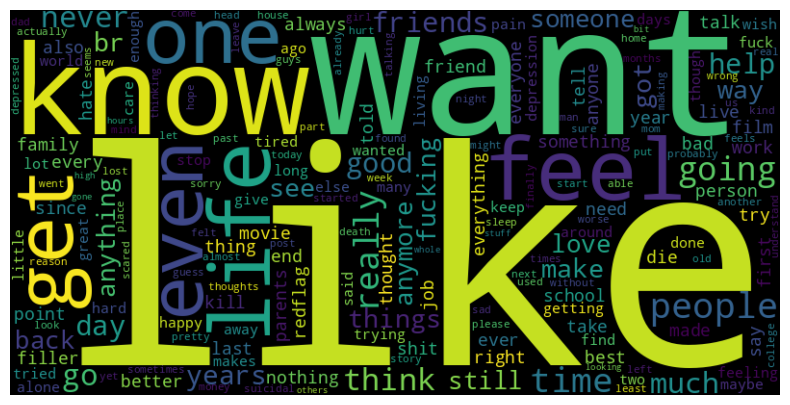

In [25]:
df_words = df.select(explode("filtered").alias("word"))

# Filter out common words or stop words if necessary
# You can use the 'stopwords' parameter in the WordCloud constructor

# Convert the DataFrame to Pandas for WordCloud generation
wordcloud_data = df_words.groupBy("word").count().toPandas()

# Generate the WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="black").generate_from_frequencies(wordcloud_data.set_index("word")["count"].to_dict())

# Display the WordCloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [26]:
def remove_empty_strings(array):
   return [x for x in array if x != '']

remove_empty_strings_udf = udf(remove_empty_strings, ArrayType(StringType()))

df = df.withColumn("lemmatized", remove_empty_strings_udf(df["lemmatized"]))

In [27]:
df.show(5)

+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+
|                text|label|length|      extracted_text|             tokened|            filtered|          lemmatized|
+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+
|music recommendat...|    0|   450|music recommendat...|[music, recommend...|[music, recommend...|[music, recommend...|
|im done trying fe...|    1|   594|i am done trying ...|[i, am, done, try...|[done, trying, fe...|[do, try, feel, b...|
|hey rredflag sure...|    1|   411|hey rredflag sure...|[hey, rredflag, s...|[hey, rredflag, s...|[hey, rredflag, s...|
|trying rd time k ...|    0|    29|trying rd time k ...|[trying, rd, time...|[trying, rd, time...|[try, rd, time, k...|
|got told im lot p...|    0|   141|got told i am lot...|[got, told, i, am...|[got, told, lot, ...|[get, tell, lot, ...|
+--------------------+-----+------+-----

In [28]:
hashingTF = HashingTF(inputCol="lemmatized", outputCol="rawFeatures", numFeatures=1000)
df = hashingTF.transform(df)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(df)
df = idfModel.transform(df)

In [29]:
df.show(5)

+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|label|length|      extracted_text|             tokened|            filtered|          lemmatized|         rawFeatures|            features|
+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|music recommendat...|    0|   450|music recommendat...|[music, recommend...|[music, recommend...|[music, recommend...|(1000,[15,70,82,8...|(1000,[15,70,82,8...|
|im done trying fe...|    1|   594|i am done trying ...|[i, am, done, try...|[done, trying, fe...|[do, try, feel, b...|(1000,[69,87,114,...|(1000,[69,87,114,...|
|hey rredflag sure...|    1|   411|hey rredflag sure...|[hey, rredflag, s...|[hey, rredflag, s...|[hey, rredflag, s...|(1000,[167,182,18...|(1000,[167,182,18...|
|trying rd time k ...|    0|

In [30]:
df = df.drop('tokened')
df = df.drop('filtered')
df = df.drop('lemmatized')
df = df.drop('extracted_text')

In [31]:
df.show(5)

+--------------------+-----+------+--------------------+--------------------+
|                text|label|length|         rawFeatures|            features|
+--------------------+-----+------+--------------------+--------------------+
|music recommendat...|    0|   450|(1000,[15,70,82,8...|(1000,[15,70,82,8...|
|im done trying fe...|    1|   594|(1000,[69,87,114,...|(1000,[69,87,114,...|
|hey rredflag sure...|    1|   411|(1000,[167,182,18...|(1000,[167,182,18...|
|trying rd time k ...|    0|    29|(1000,[55,157,541...|(1000,[55,157,541...|
|got told im lot p...|    0|   141|(1000,[29,115,146...|(1000,[29,115,146...|
+--------------------+-----+------+--------------------+--------------------+
only showing top 5 rows



In [32]:
(train, test) = df.randomSplit([0.8,0.2], seed=2023)

In [33]:
layers = [1000, 5, 4, 2]

In [35]:
rf = RandomForestClassifier()

In [36]:
model = rf.fit(train)

In [37]:
predictions = model.transform(test)

In [38]:
predictions.show(5)

+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+----------+
|                text|label|length|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+----------+
| anyone wanna cha...|    0|   107|(1000,[114,124,14...|(1000,[114,124,14...|[11.6213991926525...|[0.58106995963262...|       0.0|
| caliber put down...|    1|   146|(1000,[15,133,228...|(1000,[15,133,228...|[11.7756424869967...|[0.58878212434983...|       0.0|
| dollar sucky suc...|    0|    31|(1000,[2,76,319,3...|(1000,[2,76,319,3...|[13.6130957390960...|[0.68065478695480...|       0.0|
| hours i hopeim i...|    1|   587|(1000,[34,42,44,9...|(1000,[34,42,44,9...|[8.56727418596381...|[0.42836370929819...|       1.0|
| hours much read ...|    1|    58|(1000,[157,403,52...|(1000,[157,403,52...|[12.49

In [39]:
pred_result = predictions.collect()

In [40]:
pred_df = spark.createDataFrame(pred_result)

In [43]:
summary = model.summary
print("")

In [44]:
evaluator = MulticlassClassificationEvaluator(labelCol = 'label')

In [45]:
# Extract labels and predictions as lists
labels = labels = pred_df.select("label").rdd.map(lambda x: x[0]).collect()
predicted_labels = labels = pred_df.select("prediction").rdd.map(lambda x: x[0]).collect()
# Find unique labels
unique_labels = sorted(set(labels + predicted_labels))

# Create a confusion matrix
conf_matrix = [[0] * len(unique_labels) for _ in range(len(unique_labels))]

for true_label, pred_label in zip(labels, predicted_labels):
    conf_matrix[int(true_label)][int(pred_label)] += 1

# Display the confusion matrix
print("Confusion Matrix:")
for row in conf_matrix:
    print(row)

Confusion Matrix:
[3422, 0]
[0, 2137]


In [46]:
# Calculate precision, recall, F1 score, and accuracy
precision = evaluator.evaluate(pred_df, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(pred_df, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(pred_df, {evaluator.metricName: "f1"})
accuracy = evaluator.evaluate(pred_df, {evaluator.metricName: "accuracy"})

# Display the classification report
print("Classification Report:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Classification Report:
Precision: 0.7926
Recall: 0.7809
F1 Score: 0.7780
Accuracy: 0.7809


In [47]:
evaluator = BinaryClassificationEvaluator()
auc = evaluator.evaluate(pred_df, {evaluator.metricName: "areaUnderROC"})
print("Area Under ROC:", auc)

Area Under ROC: 0.8599031141778883


In [48]:
# create predict one
def predict_one(text):
    df_one = spark.createDataFrame([(text,)], ['text'])
    # remove symbols with regex
    df_one = df_one.withColumn('text', regexp_replace(col('text'), '[^\sa-zA-Z0-9]', ''))
    # lowercase
    df_one = df_one.withColumn('text', lower(col('text')))
    # extract text
    df_one = df_one.withColumn('extracted_text', extract_text_udf('text'))
    df_one = tokenizer.transform(df_one)
    df_one = stopwords_remover.transform(df_one)
    df_one = df_one.withColumn('lemmatized', lemmatize_udf(df_one['filtered']))
    df_one = hashingTF.transform(df_one)
    df_one = idfModel.transform(df_one)
    return model.transform(df_one).collect()[0]['prediction']


In [49]:
user_input = input("Enter a sentence: ")
prediction = predict_one(user_input)
if prediction == 1:
    print("The input suggests positive mental health.")
else:
    print("The input suggests negative mental health")

Enter a sentence: Objective function (scaled loss + regularization) at each iteration.
The input suggests negative mental health


In [59]:
user_input = input("Enter a sentence: ")
prediction = predict_one(user_input)
if prediction == 1:
    print("The input suggests positive mental health.")
else:
    print("The input suggests negative mental health")

Enter a sentence: My mind races with worried thoughts and worst-case scenarios nonstop, it's torture.
The input suggests negative mental health
